`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Boston_for_lab` (вариант 1)

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Указания к выполнению


## Загружаем пакеты

In [17]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [18]:
# константы
#  ядро для генератора случайных чисел
my_seed = 1
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Boston_for_lab` в формате .csv доступен для загрузки по адресу: <https://github.com/aksyuk/MTML/blob/main/Labs/data/Boston_for_lab.csv>. Справочник к данным можно найти по адресу: <https://github.com/aksyuk/MTML/blob/main/Labs/data/CodeBook_Boston_for_lab.md>.  

`medv` — медианная стоимость домов, занимаемых владельцами, в тысячах долларов;

`zn` — доля земли под жилую застройку, зонированная под участки более 25000 кв. футов;

`indus` — доля акров, не связанных с розничной торговлей, на город;

`tax_over_400` — фиктивная переменная: 1 если полная ставка налога на имущество \ на $10000 превышает 400.

Загружаем данные во фрейм и кодируем категориальные переменные.  

In [19]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/Boston_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [20]:
# первые 5 строк фрейма
DF_raw.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


In [22]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [23]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков не обнаружено.  

Кодировать нашу переменную tax_over_400 не надо. 

In [24]:
# оставляем в наборе данных только то, что нужно 
DF_all = DF_raw[['medv', 'zn', 'indus', 'tax_over_400']]

DF_all.columns

Index(['medv', 'zn', 'indus', 'tax_over_400'], dtype='object')

In [25]:
DF_all.dtypes

medv            float64
zn              float64
indus           float64
tax_over_400      int64
dtype: object

In [26]:
# удаляем фрейм-исходник
del DF_raw

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [27]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `medv`, которая является зависимой переменной модели, не сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `zn` принимает нулевые значения. Остальные показатели положительны.  

In [29]:
# описательные статистики для непрерывных переменных
DF[['medv', 'zn', 'indus']].describe()

,medv,zn,indus
count,405.000000,405.000000,405.000000
mean,22.653580,11.646914,11.023111
std,9.142774,23.673496,6.809215
min,5.600000,0.000000,0.740000
25%,17.100000,0.000000,5.130000
50%,21.500000,0.000000,8.560000
75%,25.300000,12.500000,18.100000
max,50.000000,100.000000,27.740000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

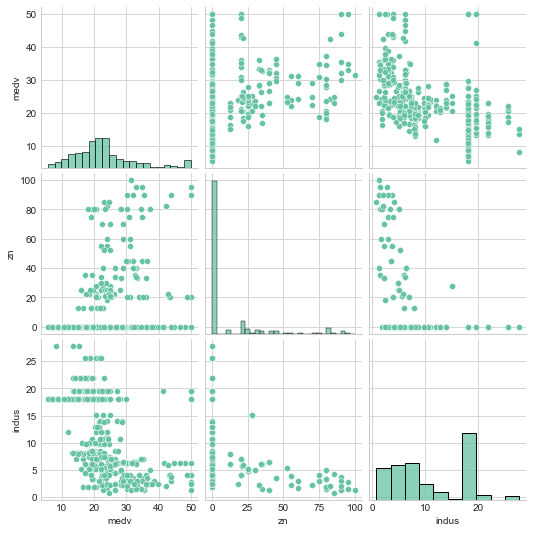

In [30]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['medv', 'zn', 'indus']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `medv` похоже на нормальное;  
* из всех объясняющих скорее всего нормально распределена только `medv`;  
* на графике разброса `medv` и `indus` заметно облако скоплений; 

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от .  

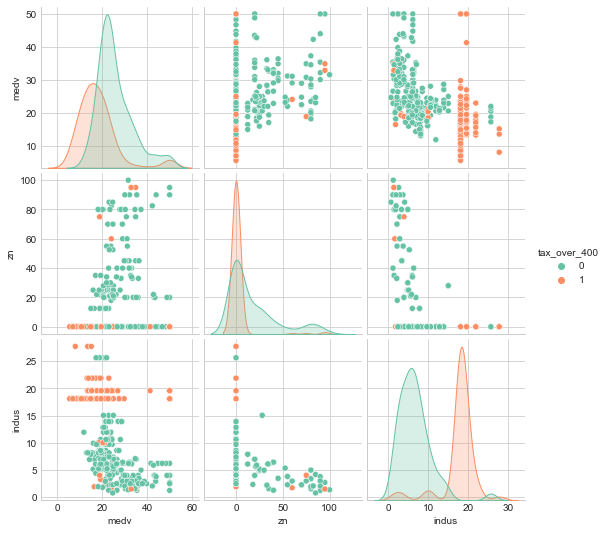

In [31]:
# матричный график разброса с цветом по полу
sns.pairplot(DF[['medv', 'zn', 'indus', 'tax_over_400']],
            hue='tax_over_400')

plt.show()

Здесь фиктивная переменная tax_over_400 явно влияет на стоимость домов:
* медианная стоимость для домов с налогом выше 400 дешевле, чем для домов с налогом ниже



ХЗХЗХЗХЗХЗХЗХЗХЗ
* доли земли под жилую застройку гораздо выше у домов с налогом выше 400, и ниже у домов с налогом <400
* доля акров, не связанных с розничной торговли гораздо ниже у домов с налогом ниже 400 

* на графике зависимости стоимости от доли земли под жилую застройку, зонированная под участки более 25000 кв. футов видно, что .....


Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [33]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'zn', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,zn,indus
medv,1.00,0.34,-0.47
zn,0.34,1.00,-0.53
indus,-0.47,-0.53,1.00


Без разбиения на классы наблюдений по фиктивным переменным максимальная теснота линейной взаимосвязи соответствует коэффициенту корреляции 0.34 между `medv` и `zn` . 

Посчитаем корреляционные матрицы для домов с налогом <400 и >400. 

In [35]:
# корреляционная матрица по классу налог >400
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'zn', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,zn,indus
medv,1.00,0.19,-0.13
zn,0.19,1.00,-0.57
indus,-0.13,-0.57,1.00


In [36]:
# корреляционная матрица по классу налог <400
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'zn', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,zn,indus
medv,1.00,0.29,-0.38
zn,0.29,1.00,-0.46
indus,-0.38,-0.46,1.00


Можно убедиться, что линейные связи с учётом `tax_over_400` не усиливаются, но во всех 3 матрица `medv` явно связана с `zn` гораздо больше.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [40]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])

# описательные статистики для непрерывных показателей
DF[['medv', 'zn', 'indus']].describe()

,medv,zn,indus
count,405.000000,405.000000,405.000000
mean,22.653580,11.646914,11.023111
std,9.142774,23.673496,6.809215
min,5.600000,0.000000,0.740000
25%,17.100000,0.000000,5.130000
50%,21.500000,0.000000,8.560000
75%,25.300000,12.500000,18.100000
max,50.000000,100.000000,27.740000


Проведём формальные тесты на нормальность.  

In [41]:
# тестируем на нормальность
for col in ['medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

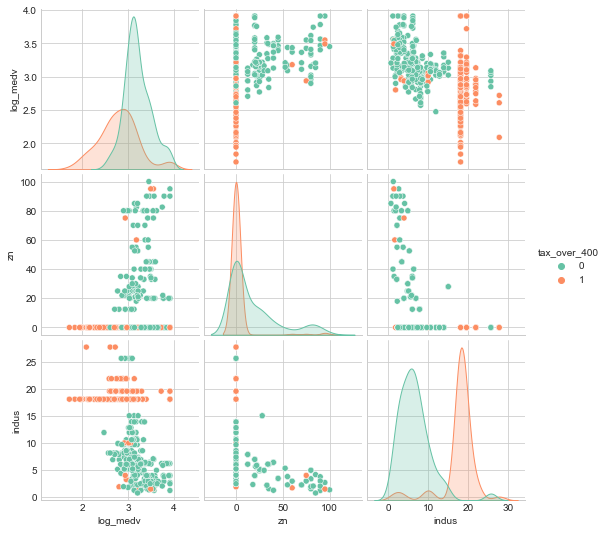

In [43]:
# матричный график разброса с цветом по smokerYes
sns.pairplot(DF[['log_medv', 'zn', 'indus', 'tax_over_400']], hue='tax_over_400')
plt.show()

In [44]:
# корреляционная матрица по классу налог >400
corr_mat = DF.loc[DF['tax_over_400'] == 1][['log_medv', 'zn', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,zn,indus
log_medv,1.00,0.19,-0.17
zn,0.19,1.00,-0.57
indus,-0.17,-0.57,1.00


In [45]:
# корреляционная матрица по классу налог <400
corr_mat = DF.loc[DF['tax_over_400'] == 0][['log_medv', 'zn', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,zn,indus
log_medv,1.00,0.31,-0.39
zn,0.31,1.00,-0.46
indus,-0.39,-0.46,1.00


## Вывод по логарифмированию:
Тест Шапиро показывает, что лог переменная также ненормально, к тому же график функции плотности выглядит также как и у не лог переменной. Матрицы корреляций меняются незначительно, следовательно переменную можно не логарифмировать. 

---

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot zn + \hat{\beta_3} \cdot indus$
1. `fit_lm_2`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot zn \cdot tax\_over\_400 + \hat{\beta_3} \cdot indus$
1. `fit_lm_3`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus \cdot tax\_over\_400 + \hat{\beta_3} \cdot zn$
1. `fit_lm_4`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus \cdot tax\_over\_400 + \hat{\beta_3} \cdot zn \cdot tax\_over\_400$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_medv}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_medv}$



### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [55]:
# данные для моделей 1, 5
df1 = DF[['medv', 'tax_over_400', 'zn', 'indus']]

# данные для моделей 2, 6
df2 = DF[['medv', 'tax_over_400', 'zn', 'indus']]
df2.loc[:, 'zn_tax_over_400'] = df2.loc[:, 'zn'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['zn'], axis=1)

# данные для моделей 3, 7
df3 = DF[['medv', 'tax_over_400', 'zn', 'indus']]
df3.loc[:, 'indus_tax_over_400'] = df3.loc[:, 'indus'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['indus'], axis=1)

# данные для моделей 4, 8
df4 = DF[['medv', 'tax_over_400', 'zn', 'indus']]
df4.loc[:, 'zn_tax_over_400'] = df4.loc[:, 'zn'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'indus_tax_over_400'] = df4.loc[:, 'indus'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['indus', 'zn'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_medv'], axis=1)

In [62]:
# проверка результатов
df4.head(5)

,medv,tax_over_400,zn_tax_over_400,indus_tax_over_400
307,28.2,0,0.0,0.0
343,23.9,0,0.0,0.0
47,16.6,0,0.0,0.0
67,22.0,0,0.0,0.0
362,20.8,1,0.0,18.1


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `medv` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [65]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [27.404] 
 объясняющие  ['zn', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 0.055 -0.407 -2.268]]


In [66]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([7.95189075])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [67]:
# модель со всеми объясняющими, y_log
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.282] 
 объясняющие  ['zn', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 0.002 -0.018 -0.18 ]]


In [69]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[  0.2,  -1.7, -16.5]])

In [70]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([8.02104453])

In [73]:
print('MSE_train модели для medv меньше MSE_train',
     'модели для log(medv) в ', np.around(MSE_log / MSE, 3), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [1.017] раз


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [74]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = df.medv
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 6.66 секунд


In [75]:
df0.shape

(405, 4)

In [76]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 7.06 секунд


Сравним ошибки для моделей на исходных значениях `medv` с ошибками моделей на логарифме.  

In [78]:
[np.around(-x, 2) for x in scores]

[64.36, 64.36, 65.45, 66.55, 69.5]

In [79]:
[np.around(-x, 3) for x in scores_log]

[0.114, 0.114, 0.115, 0.117, 0.122]

Определим самые точные модели отдельно на `medv` и на `log_medv`.  

In [83]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 64.362


In [82]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0_log :
MSE_loocv = 0.114


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [84]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.23 секунд


In [85]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.22 секунд


In [88]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 64.446


In [89]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 0.114


Можно убедиться, что оценка MSE методом перекрёстной проверки по 10 блокам даёт результаты, практически идентичные методу LOOCV. При этом скорость у первого метода гораздо выше.

Самой точной среди моделей для `medv` оказалась `fit_lm_0`, а среди моделей для `log_medv` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [97]:
# прогноз по fit_lm_0
# модель
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0 на отложенных наблюдениях = 64.34


In [99]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 62.18


Очевидно, на выборке для прогноза точнее модель `fit_lm_0_log`:  
$\hat{medv\_log} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot zn + \hat{\beta_3} \cdot indus$

In [102]:
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['medv'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.282] 
 объясняющие  ['zn', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 0.002 -0.018 -0.18 ]]
